# Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

try:
    from Bio import SeqIO
except ModuleNotFoundError:
    !pip install Bio
    from Bio import SeqIO

try:
    from joblib import Parallel, delayed
except ModuleNotFoundError:
    !pip install joblib
    from joblib import Parallel, delayed

import MotifFinding as mf

# Seed Numpy
seed_value = 115
np.random.seed(seed_value)
rng = np.random.default_rng(seed_value)

# Funciones para testear

In [15]:
def test(w,N,M):
    alpha = ["A","C","G","T"]
    
    #creacion del motif
    motif = ""
    for i in range(w):
        motif += rng.choice(alpha)
    
    #secuencias
    S=[]
    A=[]
    for _ in range(N):
        u = rng.integers(M-w)
        A.append(u)
        seq="".join(rng.choice(alpha,size=u))
        seq += motif
        seq += "".join(rng.choice(alpha,size=M-w-u))
        S.append(seq) 
    return S, motif, np.array(A)

In [3]:
#testeo rapido de resumen
def test_alg(fun,theta,TEST,hparams_arg):
    #fun: algoritmo para encontrar motifs
    #theta: parametros del algoritmo segun sea el caso (n,R,lam) para MHS, y RWMFA no considera R
    #TEST: un test de la forma (Secuencia, motif a buscar, alineamiento del motif)
    #hparams_arg: los hparams de siempre (Secuencias,largo motif, modelo de fondo) 

    #simulacion
    seq, motif, alin = TEST
    hparams=hparams_arg.copy()
    NAME=fun.__name__
    #correr el algoritmo caso de multiples cadenas o no
    if (NAME=="MHS") or (NAME=="RWMFA"):
        arg= (mf.alineador(hparams),theta[0],theta[2],hparams)

        t0=time()
        trays=fun(*arg)
        delta=time()-t0

        # Reporte
        print(f"|-------------REPORTE DE ALGORITMO {NAME}-------------|")
        # Tiempo 
        print(f"Tiempo del algoritmo:",delta)

        # Precision
        alpha = (trays[-1]==alin)
        exito = np.sum(alpha)/len(alin)
        print("Indice de exito:",exito)

        # PWM
        print("Motif simulado:",motif)
        print("PWM: |A C G T|")
        print(mf.PWM(trays[-1],hparams).astype(float))
        
        # Grafico de energia
        E=[]
        for i in range(len(trays)):
            E.append(mf.H(trays[i],hparams))

        plt.plot(E)
        plt.xlabel("Iteraciones")
        plt.ylabel("H")
        plt.title(f"Evolucion de energia algoritmo {NAME}")
        plt.show()

    elif (NAME=="BATCHER") or (NAME=="BATCHER2"):
        arg= (theta[0],theta[1],theta[2],theta[3],hparams)

        t0=time()
        trays=fun(*arg)
        delta=time()-t0

        # Reporte
        print(f"|-------------REPORTE DE ALGORITMO {NAME}-------------|")
        # Tiempo 
        print(f"Tiempo del algoritmo:",delta)

        # Precision
        alpha = (trays==alin)
        exito = np.sum(alpha)/len(alin)
        print("Indice de exito:",exito)

        # PWM
        print("Motif simulado:",motif)
        print("PWM: |A C G T|")
        print(mf.PWM(trays,hparams).astype(float))
        
    else:
        arg= (theta[0],theta[1],theta[2],hparams)

        t0=time()
        trays=fun(*arg)
        delta=time()-t0

        # Reporte
        print(f"|-------------REPORTE DE ALGORITMO {NAME}-------------|")
        # Tiempo 
        print(f"Tiempo del algoritmo:",delta)

        # Precision
        alpha = (trays[0][-1]==alin)
        exito = np.sum(alpha)/len(alin)
        print("Indice de exito:",exito)

        # PWM
        print("Motif simulado:",motif)
        print("PWM: |A C G T|")
        print(mf.PWM(trays[0][-1],hparams).astype(float))
        
        # Grafico de energia
        n=len(trays[0])
        R=theta[1]

        #grafico de trayectorias
        G=[]
        for i in range(R):
            G.append([])

        for i in range(R):
            for j in range(n):
                G[i].append(mf.H(trays[i][j],hparams))
            plt.plot(G[i])
            
        plt.xlabel("Iteraciones")
        plt.ylabel("H")
        plt.title(f"Evolucion de energia algoritmo {NAME}")
        
    return delta, exito

# Test RaWaMoFiA

In [16]:
TEST_rw= test(5,10,20)
hparams_rw=[TEST_rw[0],5,[0.25,0.25,0.25,0.25]]

c:\Users\SEBA PC\Desktop\motifs\MotifFinding.py:502: RuntimeWarning: overflow encountered in exp
  paso =min(1,np.exp(lam*H_diff))


|-------------REPORTE DE ALGORITMO RWMFA-------------|
Tiempo del algoritmo: 0.18604278564453125
Indice de exito: 0.5
Motif simulado: CACCA
PWM: |A C G T|
[[0.20555556 0.56111111 0.20555556 0.02777778]
 [0.65       0.29444444 0.02777778 0.02777778]
 [0.11666667 0.73888889 0.11666667 0.02777778]
 [0.20555556 0.65       0.02777778 0.11666667]
 [0.65       0.11666667 0.20555556 0.02777778]]


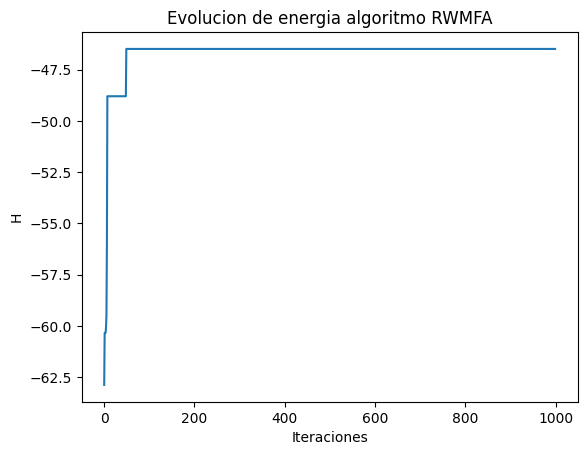

In [17]:
delta_rw1,exit_rw1= test_alg(mf.RWMFA,(1000,1,1e5),TEST_rw,hparams_rw)

|-------------REPORTE DE ALGORITMO RWMFA-------------|
Tiempo del algoritmo: 1.9390873908996582
Indice de exito: 0.7
Motif simulado: CACCA
PWM: |A C G T|
[[0.02777778 0.91666667 0.02777778 0.02777778]
 [0.65       0.20555556 0.02777778 0.11666667]
 [0.20555556 0.65       0.02777778 0.11666667]
 [0.02777778 0.82777778 0.11666667 0.02777778]
 [0.65       0.20555556 0.02777778 0.11666667]]


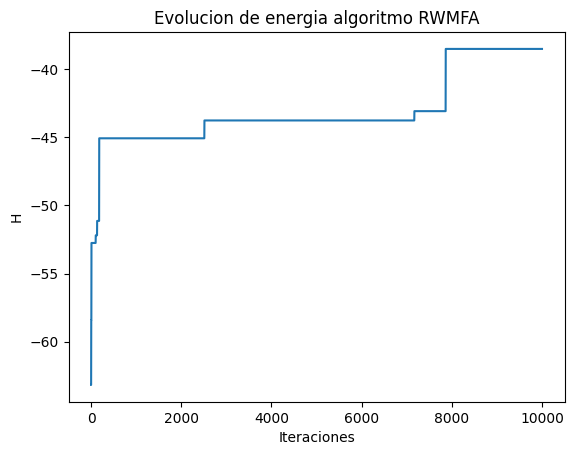

In [18]:
delta_rw2,exit_rw2= test_alg(mf.RWMFA,(10000,1,1e5),TEST_rw,hparams_rw)

|-------------REPORTE DE ALGORITMO RWMFA-------------|
Tiempo del algoritmo: 17.703004121780396
Indice de exito: 0.0
Motif simulado: CACCA
PWM: |A C G T|
[[0.02777778 0.82777778 0.11666667 0.02777778]
 [0.11666667 0.73888889 0.11666667 0.02777778]
 [0.82777778 0.02777778 0.02777778 0.11666667]
 [0.20555556 0.56111111 0.02777778 0.20555556]
 [0.20555556 0.47222222 0.29444444 0.02777778]]


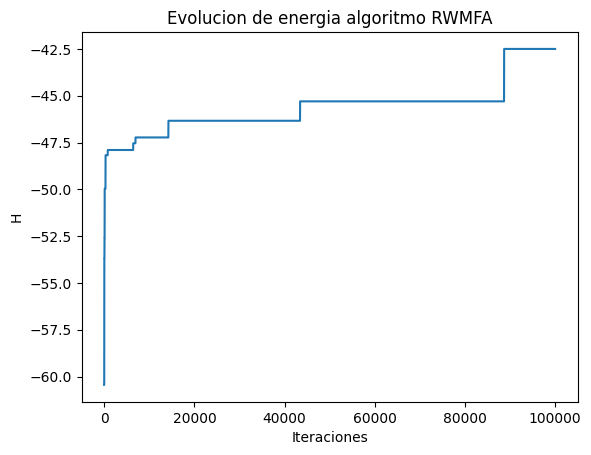

In [19]:
delta_rw3,exit_rw3= test_alg(mf.RWMFA,(100000,1,1e5),TEST_rw,hparams_rw)

In [20]:
dict_test_RW={"Iteraciones":["1000","10000","100000"],"Tiempo de demora":[delta_rw1,delta_rw2,delta_rw3],"Exito":[exit_rw1,exit_rw2,exit_rw3]}

df_test_RWMFA = pd.DataFrame(dict_test_RW)
print(df_test_RWMFA.to_latex())

\begin{tabular}{llrr}
\toprule
 & Iteraciones & Tiempo de demora & Exito \\
\midrule
0 & 1000 & 0.186043 & 0.500000 \\
1 & 10000 & 1.939087 & 0.700000 \\
2 & 100000 & 17.703004 & 0.000000 \\
\bottomrule
\end{tabular}



Text(0.5, 1.0, 'Resultados de tiempo RWMFA')

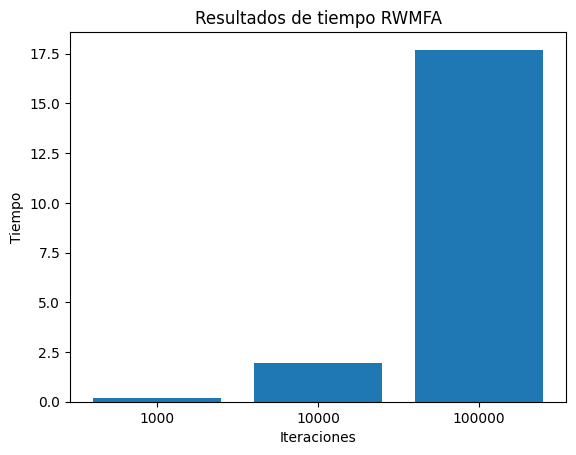

In [21]:
#graficos de tiempos
plt.bar(dict_test_RW["Iteraciones"],dict_test_RW["Tiempo de demora"])

# Etiquetas y título
plt.xlabel('Iteraciones')
plt.ylabel('Tiempo')
plt.title('Resultados de tiempo RWMFA')

Text(0.5, 1.0, 'Resultados de exito de alineamientos RWMFA')

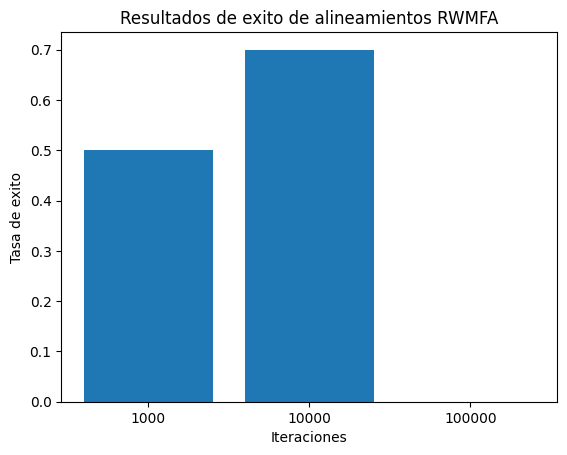

In [22]:
#graficos de exito
plt.bar(dict_test_RW["Iteraciones"],dict_test_RW["Exito"])

# Etiquetas y título
plt.xlabel('Iteraciones')
plt.ylabel('Tasa de exito')
plt.title('Resultados de exito de alineamientos RWMFA')

# Test PMC y IMC

## Test pequeño

In [23]:
TEST_p = test(5,10,20)
hparams_p=[TEST_p[0],5,[0.25,0.25,0.25,0.25]]


|-------------REPORTE DE ALGORITMO IMC-------------|
Tiempo del algoritmo: 0.8151886463165283
Indice de exito: 1.0
Motif simulado: CTGTG
PWM: |A C G T|
[[0.02777778 0.91666667 0.02777778 0.02777778]
 [0.02777778 0.02777778 0.02777778 0.91666667]
 [0.02777778 0.02777778 0.91666667 0.02777778]
 [0.02777778 0.02777778 0.02777778 0.91666667]
 [0.02777778 0.02777778 0.91666667 0.02777778]]


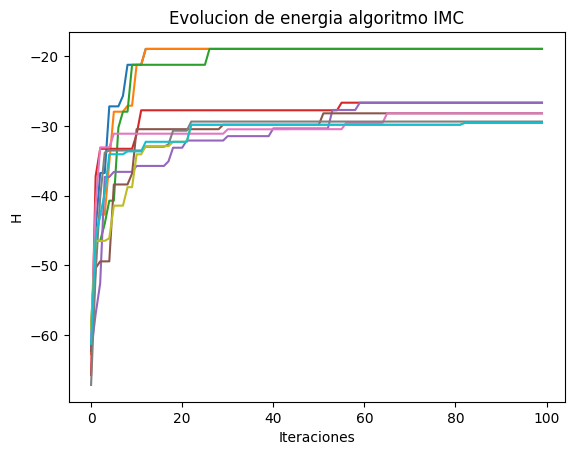

In [26]:
delta_IMC1,exit_IMC1= test_alg(mf.IMC,(100,10,1e15),TEST_p,hparams_p)

|-------------REPORTE DE ALGORITMO PMC-------------|
Tiempo del algoritmo: 14.862539529800415
Indice de exito: 1.0
Motif simulado: CTGTG
PWM: |A C G T|
[[0.02777778 0.91666667 0.02777778 0.02777778]
 [0.02777778 0.02777778 0.02777778 0.91666667]
 [0.02777778 0.02777778 0.91666667 0.02777778]
 [0.02777778 0.02777778 0.02777778 0.91666667]
 [0.02777778 0.02777778 0.91666667 0.02777778]]


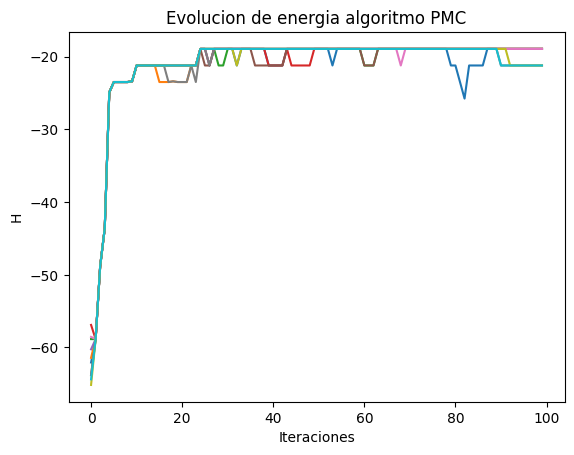

In [27]:
delta_PMC1,exit_PMC1= test_alg(mf.PMC,(100,10,1e15),TEST_p,hparams_p)

## Test mediano

In [28]:
TEST_m= test(15,20,50)
hparams_m=[TEST_m[0],15,[0.25,0.25,0.25,0.25]]

|-------------REPORTE DE ALGORITMO IMC-------------|
Tiempo del algoritmo: 8.990647792816162
Indice de exito: 1.0
Motif simulado: ACACCCATAGCGGGC
PWM: |A C G T|
[[0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.01470588 0.01470588 0.95588235]
 [0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]]


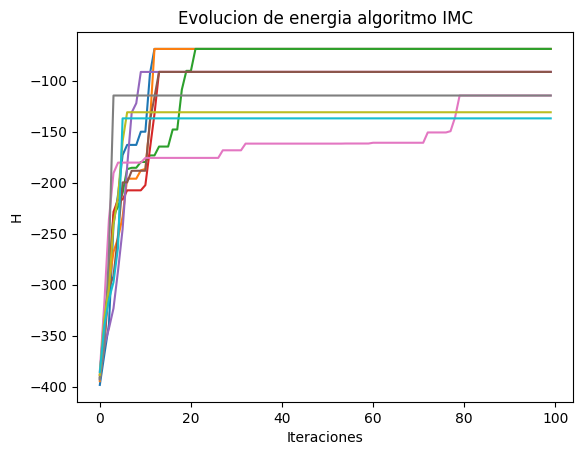

In [29]:
delta_IMC2,exit_IMC2= test_alg(mf.IMC,(100,10,1e15),TEST_m,hparams_m)

|-------------REPORTE DE ALGORITMO PMC-------------|
Tiempo del algoritmo: 124.34185147285461
Indice de exito: 1.0
Motif simulado: ACACCCATAGCGGGC
PWM: |A C G T|
[[0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.01470588 0.01470588 0.95588235]
 [0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]]


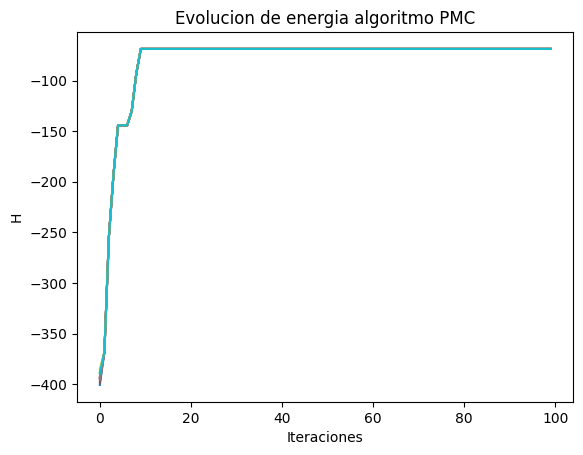

In [34]:
delta_PMC2,exit_PMC2= test_alg(mf.PMC,(100,10,1e15),TEST_m,hparams_m)

## Test grande

In [38]:
TEST_g= test(20,30,70)
hparams_g=[TEST_g[0],20,[0.25,0.25,0.25,0.25]]

|-------------REPORTE DE ALGORITMO IMC-------------|
Tiempo del algoritmo: 27.263349771499634
Indice de exito: 1.0
Motif simulado: CCGTGGTTAATGTACACCGC
PWM: |A C G T|
[[0.01 0.97 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.01 0.97]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.01 0.97]
 [0.01 0.01 0.01 0.97]
 [0.97 0.01 0.01 0.01]
 [0.97 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.97]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.01 0.97]
 [0.97 0.01 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.97 0.01 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.97 0.01 0.01]]


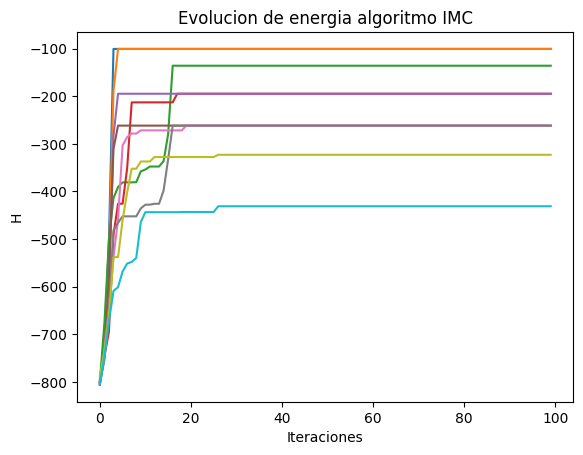

In [39]:
delta_IMC3,exit_IMC3= test_alg(mf.IMC,(100,10,1e25),TEST_g,hparams_g)

|-------------REPORTE DE ALGORITMO PMC-------------|
Tiempo del algoritmo: 323.160386800766
Indice de exito: 1.0
Motif simulado: CCGTGGTTAATGTACACCGC
PWM: |A C G T|
[[0.01 0.97 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.01 0.97]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.01 0.97]
 [0.01 0.01 0.01 0.97]
 [0.97 0.01 0.01 0.01]
 [0.97 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.97]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.01 0.97]
 [0.97 0.01 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.97 0.01 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.97 0.01 0.01]]


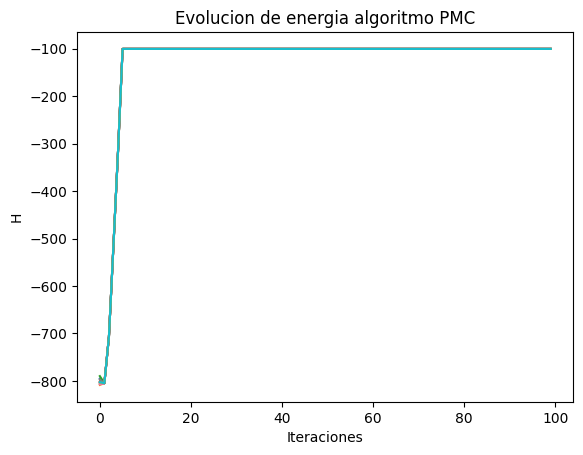

In [40]:
delta_PMC3,exit_PMC3= test_alg(mf.PMC,(100,10,1e5),TEST_g,hparams_g)

In [41]:
exito_PMC = [exit_PMC1,exit_PMC2,exit_PMC3]
tiempo_PMC = [delta_PMC1,delta_PMC2,delta_PMC3]
exito_IMC = [exit_IMC1,exit_IMC2,exit_IMC3]
tiempo_IMC = [delta_IMC1,delta_IMC2,delta_IMC3]
size = ["(5,10,20)","(15,20,50)","(20,30,70)"]

#tabla resumen
dict_PMCvIMC={"tamaños":size,"Tiempo de demora PMC":tiempo_PMC,"Tiempo de demora IMC": tiempo_IMC,"Exito PMC": exito_PMC, "Exito IMC": exito_IMC}

df_PMCvIMC = pd.DataFrame(dict_PMCvIMC)
print(df_PMCvIMC.to_latex())

\begin{tabular}{llrrrr}
\toprule
 & tamaños & Tiempo de demora PMC & Tiempo de demora IMC & Exito PMC & Exito IMC \\
\midrule
0 & (5,10,20) & 14.862540 & 0.815189 & 1.000000 & 1.000000 \\
1 & (15,20,50) & 124.341851 & 8.990648 & 1.000000 & 1.000000 \\
2 & (20,30,70) & 323.160387 & 27.263350 & 1.000000 & 1.000000 \\
\bottomrule
\end{tabular}



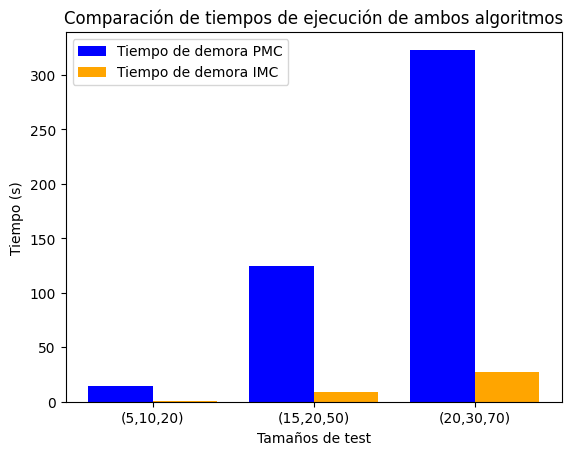

In [42]:
# tiempo 
# Configurar posiciones para las barras
x = np.arange(len(size))  # Posiciones base de las categorías
ancho = 0.4  # Ancho de cada barra

# Crear barras agrupadas
plt.bar(x - ancho/2, tiempo_PMC, width=ancho, label="Tiempo de demora PMC", color='blue')
plt.bar(x + ancho/2, tiempo_IMC, width=ancho, label="Tiempo de demora IMC", color='orange')

# Añadir etiquetas y título
plt.xticks(x, size)  # Etiquetas de las categorías en el eje X
plt.xlabel('Tamaños de test')
plt.ylabel('Tiempo (s)')
plt.title('Comparación de tiempos de ejecución de ambos algoritmos')
plt.legend()


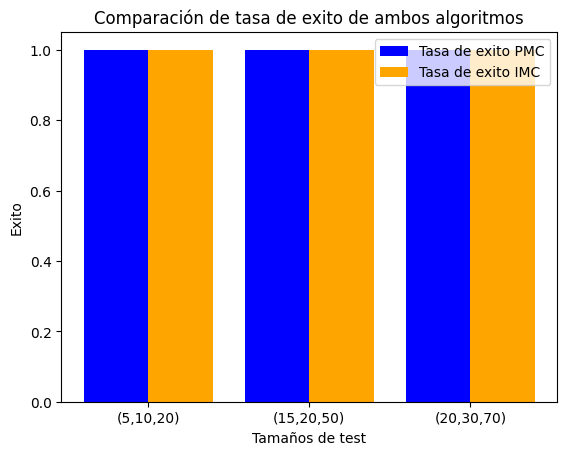

In [43]:
# exito
# Configurar posiciones para las barras
x = np.arange(len(size))  # Posiciones base de las categorías
ancho = 0.4  # Ancho de cada barra

# Crear barras agrupadas
plt.bar(x - ancho/2, exito_PMC, width=ancho, label="Tasa de exito PMC", color='blue')
plt.bar(x + ancho/2, exito_IMC, width=ancho, label="Tasa de exito IMC", color='orange')

# Añadir etiquetas y título
plt.xticks(x, size)  # Etiquetas de las categorías en el eje X
plt.xlabel('Tamaños de test')
plt.ylabel('Exito')
plt.title('Comparación de tasa de exito de ambos algoritmos')
plt.legend()

# Batcher y comparación con PMC y IMC

## Test mediano

In [44]:
delta_BATCHER2,exit_BATCHER2= test_alg(mf.BATCHER,(100,10,1e15,0.5),TEST_m,hparams_m)

|-------------REPORTE DE ALGORITMO BATCHER-------------|
Tiempo del algoritmo: 6.635999917984009
Indice de exito: 1.0
Motif simulado: ACACCCATAGCGGGC
PWM: |A C G T|
[[0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.01470588 0.01470588 0.95588235]
 [0.95588235 0.01470588 0.01470588 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.01470588 0.95588235 0.01470588 0.01470588]]


## Test grande

In [45]:
delta_BATCHER3,exit_BATCHER3= test_alg(mf.BATCHER,(100,10,1e15,0.5),TEST_g,hparams_g)

|-------------REPORTE DE ALGORITMO BATCHER-------------|
Tiempo del algoritmo: 13.492053270339966
Indice de exito: 1.0
Motif simulado: CCGTGGTTAATGTACACCGC
PWM: |A C G T|
[[0.01 0.97 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.01 0.97]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.01 0.97]
 [0.01 0.01 0.01 0.97]
 [0.97 0.01 0.01 0.01]
 [0.97 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.97]
 [0.01 0.01 0.97 0.01]
 [0.01 0.01 0.01 0.97]
 [0.97 0.01 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.97 0.01 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.97 0.01 0.01]]


In [46]:
exito_BATCHER = [exit_BATCHER2,exit_BATCHER3]
tiempo_BATCHER = [delta_BATCHER2,delta_BATCHER3]

#tabla resumen
dict_BATCHER={"tamaños":size[1:],"Tiempo de ejecucion PMC":tiempo_PMC[1:],"Tiempo de ejecucion IMC": tiempo_IMC[1:],"Exito PMC": exito_PMC[1:], "Exito IMC": exito_IMC[1:], "Tiempo de ejecucion BATCHER":tiempo_BATCHER,"Exito BATCHER": exito_BATCHER}

df_BATCHER = pd.DataFrame(dict_PMCvIMC)
print(df_PMCvIMC.to_latex())

\begin{tabular}{llrrrr}
\toprule
 & tamaños & Tiempo de demora PMC & Tiempo de demora IMC & Exito PMC & Exito IMC \\
\midrule
0 & (5,10,20) & 14.862540 & 0.815189 & 1.000000 & 1.000000 \\
1 & (15,20,50) & 124.341851 & 8.990648 & 1.000000 & 1.000000 \\
2 & (20,30,70) & 323.160387 & 27.263350 & 1.000000 & 1.000000 \\
\bottomrule
\end{tabular}



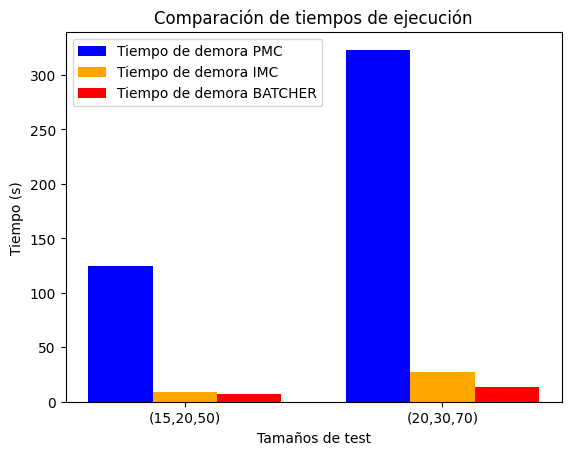

In [49]:
# tiempo 
# Configurar posiciones para las barras
x = np.arange(len(size[1:]))  # Posiciones base de las categorías
ancho = 0.25  # Ancho de cada barra

# Crear barras agrupadas
plt.bar(x - ancho, tiempo_PMC[1:], width=ancho, label="Tiempo de demora PMC", color='blue')
plt.bar(x , tiempo_IMC[1:], width=ancho, label="Tiempo de demora IMC", color='orange')
plt.bar(x + ancho, tiempo_BATCHER, width=ancho, label="Tiempo de demora BATCHER", color='red')

# Añadir etiquetas y título
plt.xticks(x, size[1:])  # Etiquetas de las categorías en el eje X
plt.xlabel('Tamaños de test')
plt.ylabel('Tiempo (s)')
plt.title('Comparación de tiempos de ejecución')
plt.legend()

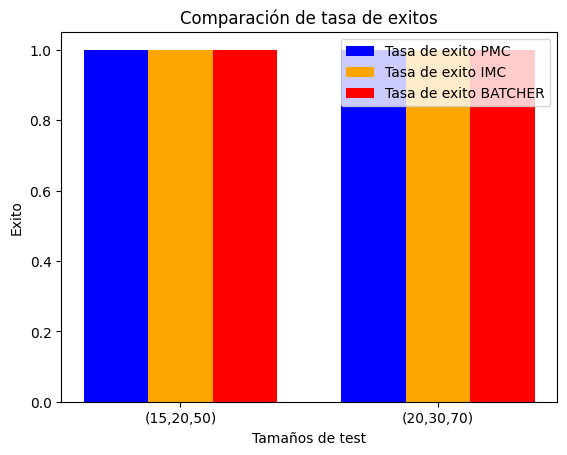

In [ ]:
# exito
# Configurar posiciones para las barras
x = np.arange(len(size[1:]))  # Posiciones base de las categorías
ancho = 0.25  # Ancho de cada barra

# Crear barras agrupadas
plt.bar(x - ancho, exito_PMC[1:], width=ancho, label="Tasa de exito PMC", color='blue')
plt.bar(x , exito_IMC[1:], width=ancho, label="Tasa de exito IMC", color='orange')
plt.bar(x + ancho, exito_BATCHER, width=ancho, label="Tasa de exito BATCHER", color='red')

# Añadir etiquetas y título
plt.xticks(x, size[1:])  # Etiquetas de las categorías en el eje X
plt.xlabel('Tamaños de test')
plt.ylabel('Exito')
plt.title('Comparación de tasa de exitos')
plt.legend()

# Ejemplo real

In [61]:
# Leyendo las secuencias
secuencias = np.zeros(38,dtype=object)
i=0
for seq_record in SeqIO.parse("MA0016.2.sites", "fasta"):
    secuencias[i]=str(seq_record.seq.upper())
    i+=1

for i in range(len(secuencias)):
    print(secuencias[i])



GGGGTCACG
TGCAGGTAG
GCGGGGTCA
GGCGGGGTC
GGGGTCACG
GGGGTCACG
GGGGTCACG
GCGACCGGG
GGGGGGTCA
GGGGTCACG
GGGGTCACG
AGAGAGGCC
GGGGTCACG
GGGGTCACG
TGGCGGGGT
GGGGGTCAC
GGGGTCACA
GGGGTCACA
GGATGCACG
GGGGTCACC
GGGGTCACT
TAGGGGTCA
GTGGGGTCA
TGGGCGGCA
GGGGTCAAG
GGGGTCAAG
GGGGTCAAG
GGGGTCATC
GGGGTCATC
GGGGTCAAC
GGGGTCATT
GGGGTCAAT
TGGAGCGGG
TGGGGTCAG
GGGGTGACA
GGGGTTGTA
GGAGAGTGG
ACAGGTCGC


In [86]:
hparams_real=[secuencias,4,[0.25,0.25,0.25,0.25]]


In [89]:
Tray_real= mf.IMC(100,10,1e23,hparams_real)[0]

In [91]:
print(np.round(mf.PWM(Tray_real[-1],hparams_real),decimals=2))
#print(secuencias[0][Tray_real[-1][0]:Tray_real[-1][0]+hparams_real[1]])

[[0.08 0.01 0.9  0.01]
 [0.03 0.08 0.87 0.01]
 [0.06 0.03 0.9  0.01]
 [0.01 0.01 0.77 0.21]]


In [ ]:
"""
# # Escritura de experimento


def write_arrays_to_file(arrays, filename):
    with open(filename, 'w') as f:
        for i, array in enumerate(arrays):
            # Convert array to space-separated string
            array_str = ' '.join(map(str, array))
            f.write(array_str + '\n')
            # Add * symbol between lines (except after the last array)
            if i < len(arrays) - 1:
                f.write('*\n')

seq, motif, A = test(5,15,20)
fondo = [0.25,0.25,0.25,0.25]
hparams = [seq,5,fondo]
testeo=mf.IMC(200,10,100,hparams)
write_arrays_to_file(testeo[0], 'trayectoria.txt')
write_arrays_to_file(seq, 'secuencias.txt')
"""

"\n# # Escritura de experimento\n\n\ndef write_arrays_to_file(arrays, filename):\n    with open(filename, 'w') as f:\n        for i, array in enumerate(arrays):\n            # Convert array to space-separated string\n            array_str = ' '.join(map(str, array))\n            f.write(array_str + '\n')\n            # Add * symbol between lines (except after the last array)\n            if i < len(arrays) - 1:\n                f.write('*\n')\n\nseq, motif, A = test(5,15,20)\nfondo = [0.25,0.25,0.25,0.25]\nhparams = [seq,5,fondo]\ntesteo=mf.IMC(200,10,100,hparams)\nwrite_arrays_to_file(testeo[0], 'trayectoria.txt')\nwrite_arrays_to_file(seq, 'secuencias.txt')\n"

In [ ]:
"""
energia=np.zeros(len(testeo[0]),dtype=object)
for i in range(len(testeo[0])): 
    energia[i]=mf.H(testeo[0][i],hparams)

with open("energia.txt", 'w') as f:
    for i in range(len(energia)):
        # Convert array to space-separated string
        array_str = str(energia[i])
        f.write(array_str + '\n')
        # Add * symbol between lines (except after the last array)
        if i < len(energia) - 1:
            f.write('*\n')
"""

'\nenergia=np.zeros(len(testeo[0]),dtype=object)\nfor i in range(len(testeo[0])): \n    energia[i]=mf.H(testeo[0][i],hparams)\n\nwith open("energia.txt", \'w\') as f:\n    for i in range(len(energia)):\n        # Convert array to space-separated string\n        array_str = str(energia[i])\n        f.write(array_str + \'\n\')\n        # Add * symbol between lines (except after the last array)\n        if i < len(energia) - 1:\n            f.write(\'*\n\')\n'

In [ ]:
"""
energias = np.zeros(10,dtype=object)
for i in range(10):
    single=np.zeros(len(testeo[0]))
    for j in range(len(testeo[0])):
        single[j]=mf.H(testeo[i][j],hparams)
    energias[i]=single

write_arrays_to_file(energias, 'energiass.txt')
"""    

"\nenergias = np.zeros(10,dtype=object)\nfor i in range(10):\n    single=np.zeros(len(testeo[0]))\n    for j in range(len(testeo[0])):\n        single[j]=mf.H(testeo[i][j],hparams)\n    energias[i]=single\n\nwrite_arrays_to_file(energias, 'energiass.txt')\n"

In [ ]:
"""   
testeo2=mf.PMC(200,10,100,hparams)
energiasPMC = np.zeros(10,dtype=object)
for i in range(10):
    single=np.zeros(len(testeo2[0]))
    for j in range(len(testeo2[0])):
        single[j]=mf.H(testeo2[i][j],hparams)
    energiasPMC[i]=single

write_arrays_to_file(energiasPMC, 'energiass2.txt')
"""    

"   \ntesteo2=mf.PMC(200,10,100,hparams)\nenergiasPMC = np.zeros(10,dtype=object)\nfor i in range(10):\n    single=np.zeros(len(testeo2[0]))\n    for j in range(len(testeo2[0])):\n        single[j]=mf.H(testeo2[i][j],hparams)\n    energiasPMC[i]=single\n\nwrite_arrays_to_file(energiasPMC, 'energiass2.txt')\n"

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99bb8945-6f3c-4ae9-b2bf-df2af053d17a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>